## Big Data Assignment 5 

### Data cleaning
- Removing entries where speed over ground is zero, missing, or higher than 58
- Removing undefined and law enforcement ships
- removing helicopters
- leaving lenght of MMSI = 9 for Class A and B vessels, length <= 7 for Base stations
- leaving only coordinates for the circle of 25 km radius where centre point is (55.225000, 14.245000)
- removing duplicates by MMSI and timestamp level
- saving cleaned files 


In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_timestamp, col, sin, cos, acos, length, radians, lit, when, first
from pyspark.sql.types import DoubleType
import os
import math

spark = SparkSession.builder.appName("ShipDataProcessing").getOrCreate()

file_directory = "C:/Users/User/Desktop/data_folder/raw_data/"
file_names = [f"aisdk-2021-12-{str(day).zfill(2)}.csv" for day in range(1, 32)]  # For files from Dec 1 to Dec 31

for file_name in file_names:
    file_path = os.path.join(file_directory, file_name)
    
    df = spark.read.csv(file_path, header=True)
    
    df = df.withColumnRenamed('# Timestamp', 'timestamp')\
           .withColumnRenamed('Latitude', 'lat')\
           .withColumnRenamed('Longitude', 'long')\
           .withColumnRenamed('Navigational status', 'nav_st')\
           .withColumnRenamed('Type of mobile', 'type_of_mobile')\
           .withColumnRenamed('Ship type', 'ship_type')\
           .withColumn('timestamp', to_timestamp(col('timestamp'), 'dd/MM/yyyy HH:mm:ss'))\
           .withColumn('lat', col('lat').cast(DoubleType()))\
           .withColumn('long', col('long').cast(DoubleType()))\
           .withColumn('SOG', col('SOG').cast(DoubleType()))
    
    df = df.filter(~df['nav_st'].isin(['At anchor', 'Moored', 'Engaged in fishing', 'Unknown value']))\
        .filter(col('SOG').isNotNull())\
        .filter(col('SOG') != 0)\
        .filter(col('SOG') < 58)\
        .filter(col('ship_type') != 'Undefined')\
        .filter(col('ship_type') != 'Law enforcement')\
        .filter(col('type_of_mobile') != 'SAR airborne')\
        .filter(col('MMSI') != 111219507)
    
    df = df.filter(
        (
            (col('type_of_mobile') == 'Class A') & (length(col('MMSI')) == 9)
        ) | (
            (col('type_of_mobile') == 'Class B') & (length(col('MMSI')) == 9)
        ) | (
            (col('type_of_mobile') == 'Base Station') & (length(col('MMSI')) == 7)
        )
    ).filter(
        (length(col('IMO')) <= 7) | col('IMO').isNull()
    )

    reduced_df = df.select("timestamp", "MMSI", "lat", "long", "IMO", "type_of_mobile")
    
    latitude_center = 55.225000
    longitude_center = 14.245000
    radius_km = 25

    lat_center_rad = math.radians(latitude_center)
    long_center_rad = math.radians(longitude_center)

    filtered_df = reduced_df.withColumn(
    "distance_km",
    acos(
        sin(radians(col("lat"))) * sin(lit(lat_center_rad)) +
        cos(radians(col("lat"))) * cos(lit(lat_center_rad)) *
        cos(lit(long_center_rad) - radians(col("long")))
    ) * 6371  # Earth's radius in km
    ).filter(col("distance_km") <= radius_km)

    filtered_df = filtered_df.drop("distance_km")

    filtered_df = filtered_df.dropDuplicates(['timestamp', 'MMSI'])

    output_path = f"C:/Users/User/Desktop/data_folder/manipulated_data/{file_name.replace('.csv', '')}_processed"
    filtered_df.write.csv(output_path, mode="overwrite", header=True)

    print(f"Processed and saved data for {file_name}  | rows count = {filtered_df.count()}")


Processed and saved data for aisdk-2021-12-01.csv  | rows count = 114294
Processed and saved data for aisdk-2021-12-02.csv  | rows count = 118868
Processed and saved data for aisdk-2021-12-03.csv  | rows count = 153660
Processed and saved data for aisdk-2021-12-04.csv  | rows count = 164851
Processed and saved data for aisdk-2021-12-05.csv  | rows count = 130600
Processed and saved data for aisdk-2021-12-06.csv  | rows count = 124542
Processed and saved data for aisdk-2021-12-07.csv  | rows count = 132056
Processed and saved data for aisdk-2021-12-08.csv  | rows count = 124327
Processed and saved data for aisdk-2021-12-09.csv  | rows count = 104640
Processed and saved data for aisdk-2021-12-10.csv  | rows count = 144854
Processed and saved data for aisdk-2021-12-11.csv  | rows count = 147469
Processed and saved data for aisdk-2021-12-12.csv  | rows count = 138427
Processed and saved data for aisdk-2021-12-13.csv  | rows count = 165177
Processed and saved data for aisdk-2021-12-14.csv  

### Deifining functions for the detection of closest vessels 
- resampling data to one second
- dropping entries where data is missing
- removing vessels that report time less frequent than once a minute within 20 minute window
- finding closest vessels

In [5]:
import pandas as pd
import numpy as np
import glob
from itertools import combinations
from pathlib import Path
from haversine import haversine  
import logging

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Constants
BASE_DIRECTORY = Path("C:/Users/User/Desktop/data_folder/manipulated_data/")
WINDOW_SIZE_MINUTES = 20  # 20 minutes window
MIN_REPORTS_PER_MINUTE = 1  # Minimum required frequency of reports

def generate_directories(base_directory, year, month):
    """Generate directory names for each day of a given month."""
    days_in_month = (Path(f"{base_directory}/aisdk-{year}-{month:02d}-{day:02d}_processed") 
                     for day in range(1, 32))
    return [d for d in days_in_month if d.exists()]

def read_and_process_csvs(directory):
    """Read and process CSV files in the given directory."""
    csv_files = glob.glob(str(directory / "*.csv"))
    
    if not csv_files:
        logging.warning(f"No CSV files found in {directory}")
        return None
    
    df = pd.concat((pd.read_csv(f, usecols=['timestamp', 'MMSI', 'lat', 'long']) for f in csv_files), ignore_index=True)
    
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)
    df.sort_index(inplace=True)
    
    numeric_cols = df.select_dtypes(include=[np.number])
    resampled = numeric_cols.groupby('MMSI').resample('1T').mean()

    resampled.dropna(inplace=True)
    
    if 'MMSI' in resampled.columns:
            resampled.drop(columns=['MMSI'], inplace=True)

    resampled.reset_index(inplace=True)
    return resampled

def filter_by_reporting_frequency(df, window_size_minutes, min_reports_per_minute):
    """Filter out data for vessels that report less frequently than the minimum required frequency within each 20-minute window."""
    window_size_seconds = window_size_minutes * 60
    min_reports_in_window = window_size_minutes * min_reports_per_minute

    filtered_df = pd.DataFrame()

    for mmsi, group in df.groupby('MMSI'):
        group = group.sort_values('timestamp')

        group['count_in_window'] = group.rolling(f'{window_size_seconds}S', on='timestamp')['timestamp'].count()

        consistent_group = group[group['count_in_window'] >= min_reports_in_window]

        filtered_df = pd.concat([filtered_df, consistent_group])

    filtered_df = filtered_df.drop(columns=['count_in_window'])

    return filtered_df

def find_closest_vessels(resampled):
    """Find the closest pair of vessels at each timestamp."""
    min_distance = float('inf')
    closest_pair = None
    closest_time = None
    collision_coords = None  
    
    unique_times = resampled['timestamp'].unique()
    
    for time in unique_times:
        subframe = resampled[resampled['timestamp'] == time]
        for (idx1, row1), (idx2, row2) in combinations(subframe.iterrows(), 2):
            dist = haversine((row1['lat'], row1['long']), (row2['lat'], row2['long']))
            if dist < min_distance:
                min_distance = dist
                closest_pair = (row1['MMSI'], row2['MMSI'])
                closest_time = time
                collision_coords = (
                    (row1['lat'], row1['long']),
                    (row2['lat'], row2['long'])
                )

    return min_distance, closest_pair, closest_time, collision_coords

def process_directory(directory):
    """Process each directory to find the closest vessels."""
    resampled_data = read_and_process_csvs(directory)
    
    if resampled_data is not None:
        consistent_data = filter_by_reporting_frequency(resampled_data, WINDOW_SIZE_MINUTES, MIN_REPORTS_PER_MINUTE)
        
        if consistent_data.empty:
            logging.info(f"No consistent data found for directory: {directory}")
            return None
        
        min_distance, closest_pair, closest_time, collision_coords = find_closest_vessels(consistent_data)
        
        if min_distance < float('inf'):
            print(f"Closest vessels were {closest_pair} with a distance of {min_distance:.3f} km at {collision_coords} at {closest_time}")
            return min_distance, closest_pair, closest_time, collision_coords
        else:
            logging.info(f"No close encounters found for directory: {directory}")
            return None
    else:
        logging.info(f"No data processed for directory: {directory}")
        return None

### Finding closest vessels

In [6]:

year = 2021
month = 12

overall_min_distance = float('inf')
overall_closest_pair = None
overall_closest_time = None
overall_day = None

directories = generate_directories(BASE_DIRECTORY, year, month)

for directory in directories:
    logging.info(f"Processing directory: {directory}")
    
    result = process_directory(directory)
    if result is not None:
        min_distance, closest_pair, closest_time, collision_coords = result
        if min_distance < overall_min_distance:
            overall_min_distance = min_distance
            overall_closest_pair = closest_pair
            overall_closest_time = closest_time
            overall_day = directory.name

print('------------------------------------------------------------------------------------------------------------------------------------------')
print(f"During the whole month the closest vessels were {overall_closest_pair} with a distance of {overall_min_distance:.3f} km at {collision_coords} at {overall_closest_time}")

2024-06-17 00:29:00,016 - INFO - Processing directory: C:\Users\User\Desktop\data_folder\manipulated_data\aisdk-2021-12-01_processed
2024-06-17 00:29:06,690 - INFO - Processing directory: C:\Users\User\Desktop\data_folder\manipulated_data\aisdk-2021-12-02_processed


Closest vessels were (219849000, 257737000) with a distance of 0.503 km at ((55.22183666666666, 14.412833), (55.217864666666664, 14.416623)) at 2021-12-01 00:33:00+02:00


2024-06-17 00:29:12,844 - INFO - Processing directory: C:\Users\User\Desktop\data_folder\manipulated_data\aisdk-2021-12-03_processed


Closest vessels were (246542000, 265871000) with a distance of 0.745 km at ((55.26104783333333, 14.343789166666667), (55.25836063636363, 14.354562)) at 2021-12-02 05:55:00+02:00


2024-06-17 00:29:20,720 - INFO - Processing directory: C:\Users\User\Desktop\data_folder\manipulated_data\aisdk-2021-12-04_processed


Closest vessels were (219017081, 566598000) with a distance of 0.373 km at ((55.18642534482758, 14.300980137931035), (55.18950566666667, 14.303323333333333)) at 2021-12-03 17:59:00+02:00


2024-06-17 00:29:29,806 - INFO - Processing directory: C:\Users\User\Desktop\data_folder\manipulated_data\aisdk-2021-12-05_processed


Closest vessels were (245137000, 305067000) with a distance of 0.507 km at ((55.212350333333326, 14.419541), (55.2113832, 14.427351400000001)) at 2021-12-04 06:47:00+02:00


2024-06-17 00:29:36,586 - INFO - Processing directory: C:\Users\User\Desktop\data_folder\manipulated_data\aisdk-2021-12-06_processed


Closest vessels were (246854000, 356579000) with a distance of 0.500 km at ((55.2833226, 14.488123400000001), (55.279638166666665, 14.492651166666667)) at 2021-12-05 09:26:00+02:00


2024-06-17 00:29:43,090 - INFO - Processing directory: C:\Users\User\Desktop\data_folder\manipulated_data\aisdk-2021-12-07_processed


Closest vessels were (273357260, 304833000) with a distance of 0.659 km at ((55.32760216666667, 14.423323166666668), (55.33072845, 14.414464899999999)) at 2021-12-06 02:00:00+02:00


2024-06-17 00:29:49,255 - INFO - Processing directory: C:\Users\User\Desktop\data_folder\manipulated_data\aisdk-2021-12-08_processed


Closest vessels were (209114000, 305210000) with a distance of 0.612 km at ((55.175419, 14.250002666666667), (55.17011349999999, 14.247410666666667)) at 2021-12-07 11:52:00+02:00


2024-06-17 00:29:55,188 - INFO - Processing directory: C:\Users\User\Desktop\data_folder\manipulated_data\aisdk-2021-12-09_processed


Closest vessels were (244234000, 258407000) with a distance of 0.530 km at ((55.23512633333333, 13.917184333333333), (55.2398332, 13.918454)) at 2021-12-08 20:11:00+02:00


2024-06-17 00:30:00,160 - INFO - Processing directory: C:\Users\User\Desktop\data_folder\manipulated_data\aisdk-2021-12-10_processed


Closest vessels were (212787000, 258751000) with a distance of 0.560 km at ((55.316422375, 14.550534125), (55.320397500000006, 14.545106833333334)) at 2021-12-09 16:48:00+02:00


2024-06-17 00:30:07,317 - INFO - Processing directory: C:\Users\User\Desktop\data_folder\manipulated_data\aisdk-2021-12-11_processed


Closest vessels were (304030000, 477151900) with a distance of 0.518 km at ((55.31435083333333, 14.528711666666666), (55.317325000000004, 14.5224087)) at 2021-12-10 13:26:00+02:00


2024-06-17 00:30:14,792 - INFO - Processing directory: C:\Users\User\Desktop\data_folder\manipulated_data\aisdk-2021-12-12_processed


Closest vessels were (211302790, 305662000) with a distance of 0.563 km at ((55.35615466666667, 14.436940333333332), (55.3578855, 14.4285765)) at 2021-12-11 12:16:00+02:00


2024-06-17 00:30:22,328 - INFO - Processing directory: C:\Users\User\Desktop\data_folder\manipulated_data\aisdk-2021-12-13_processed


Closest vessels were (219927000, 245815000) with a distance of 0.387 km at ((55.16149063157895, 14.262324473684211), (55.164969500000005, 14.262011666666666)) at 2021-12-12 08:03:00+02:00


2024-06-17 00:30:30,379 - INFO - Processing directory: C:\Users\User\Desktop\data_folder\manipulated_data\aisdk-2021-12-14_processed


Closest vessels were (219001468, 219019015) with a distance of 0.028 km at ((55.23722216666667, 14.236150333333333), (55.237417384615384, 14.236436461538462)) at 2021-12-13 06:18:00+02:00


2024-06-17 00:30:36,578 - INFO - Processing directory: C:\Users\User\Desktop\data_folder\manipulated_data\aisdk-2021-12-15_processed


Closest vessels were (255806250, 275514000) with a distance of 0.220 km at ((55.17653, 14.3498212), (55.17524483333333, 14.352450333333332)) at 2021-12-14 09:43:00+02:00


2024-06-17 00:30:44,314 - INFO - Processing directory: C:\Users\User\Desktop\data_folder\manipulated_data\aisdk-2021-12-16_processed


Closest vessels were (219017081, 256793000) with a distance of 0.705 km at ((55.14984449999999, 14.351194785714286), (55.1559166, 14.354402200000001)) at 2021-12-15 08:13:00+02:00


2024-06-17 00:30:52,212 - INFO - Processing directory: C:\Users\User\Desktop\data_folder\manipulated_data\aisdk-2021-12-17_processed


Closest vessels were (249575000, 265871000) with a distance of 0.664 km at ((55.276658499999996, 14.342363666666666), (55.2798625, 14.33351675)) at 2021-12-16 06:01:00+02:00


2024-06-17 00:31:01,791 - INFO - Processing directory: C:\Users\User\Desktop\data_folder\manipulated_data\aisdk-2021-12-18_processed


Closest vessels were (245741000, 273339540) with a distance of 0.533 km at ((55.330757500000004, 14.427428333333333), (55.33308916666667, 14.420068166666667)) at 2021-12-17 01:52:00+02:00


2024-06-17 00:31:10,020 - INFO - Processing directory: C:\Users\User\Desktop\data_folder\manipulated_data\aisdk-2021-12-19_processed


Closest vessels were (246594000, 266465000) with a distance of 0.325 km at ((55.23985616666667, 13.972589999999999), (55.23693583333333, 13.9728535)) at 2021-12-18 22:23:00+02:00


2024-06-17 00:31:17,163 - INFO - Processing directory: C:\Users\User\Desktop\data_folder\manipulated_data\aisdk-2021-12-20_processed


Closest vessels were (245772000, 356413000) with a distance of 0.603 km at ((55.31366499999999, 14.559590833333333), (55.31773316666667, 14.553300666666667)) at 2021-12-19 23:45:00+02:00


2024-06-17 00:31:23,763 - INFO - Processing directory: C:\Users\User\Desktop\data_folder\manipulated_data\aisdk-2021-12-21_processed


Closest vessels were (245184000, 304146000) with a distance of 0.417 km at ((55.3022735, 14.52825925), (55.2990044, 14.531492600000002)) at 2021-12-20 20:37:00+02:00


2024-06-17 00:31:28,932 - INFO - Processing directory: C:\Users\User\Desktop\data_folder\manipulated_data\aisdk-2021-12-22_processed


Closest vessels were (246724000, 305295000) with a distance of 0.567 km at ((55.183902499999995, 14.354297), (55.186114599999996, 14.346248600000001)) at 2021-12-21 10:57:00+02:00


2024-06-17 00:31:35,199 - INFO - Processing directory: C:\Users\User\Desktop\data_folder\manipulated_data\aisdk-2021-12-23_processed


Closest vessels were (209488000, 266476000) with a distance of 0.633 km at ((55.27236, 14.337533666666667), (55.274180666666666, 14.328072166666667)) at 2021-12-22 08:31:00+02:00


2024-06-17 00:31:41,784 - INFO - Processing directory: C:\Users\User\Desktop\data_folder\manipulated_data\aisdk-2021-12-24_processed


Closest vessels were (219017081, 306139000) with a distance of 0.419 km at ((55.23425365517241, 14.281790793103449), (55.23162042857143, 14.277071857142857)) at 2021-12-23 14:37:00+02:00


2024-06-17 00:31:49,423 - INFO - Processing directory: C:\Users\User\Desktop\data_folder\manipulated_data\aisdk-2021-12-25_processed


Closest vessels were (210434000, 230643000) with a distance of 0.507 km at ((55.178030166666666, 14.202014499999999), (55.17478490909091, 14.20762218181818)) at 2021-12-24 20:49:00+02:00


2024-06-17 00:31:57,174 - INFO - Processing directory: C:\Users\User\Desktop\data_folder\manipulated_data\aisdk-2021-12-26_processed


Closest vessels were (257312000, 273363000) with a distance of 0.457 km at ((55.1671735, 14.0464125), (55.1631112, 14.0452876)) at 2021-12-25 15:51:00+02:00


2024-06-17 00:32:03,605 - INFO - Processing directory: C:\Users\User\Desktop\data_folder\manipulated_data\aisdk-2021-12-27_processed


Closest vessels were (209730000, 636092241) with a distance of 0.621 km at ((55.1161955, 14.2777665), (55.121608333333334, 14.275336166666667)) at 2021-12-26 08:07:00+02:00


2024-06-17 00:32:09,324 - INFO - Processing directory: C:\Users\User\Desktop\data_folder\manipulated_data\aisdk-2021-12-28_processed


Closest vessels were (245180000, 255806303) with a distance of 0.559 km at ((55.184060599999995, 14.202197799999999), (55.187806333333334, 14.196325)) at 2021-12-27 13:18:00+02:00


2024-06-17 00:32:14,680 - INFO - Processing directory: C:\Users\User\Desktop\data_folder\manipulated_data\aisdk-2021-12-29_processed


Closest vessels were (209336000, 210071000) with a distance of 0.689 km at ((55.13827799999999, 14.151192666666667), (55.1351182, 14.141870599999999)) at 2021-12-28 13:42:00+02:00


2024-06-17 00:32:20,720 - INFO - Processing directory: C:\Users\User\Desktop\data_folder\manipulated_data\aisdk-2021-12-30_processed


Closest vessels were (255805693, 275343000) with a distance of 0.665 km at ((55.170308, 14.3726628), (55.17362416666666, 14.3639545)) at 2021-12-29 08:54:00+02:00


2024-06-17 00:32:27,149 - INFO - Processing directory: C:\Users\User\Desktop\data_folder\manipulated_data\aisdk-2021-12-31_processed


Closest vessels were (211881000, 219017081) with a distance of 0.801 km at ((55.21627566666666, 14.275430666666667), (55.223302137931036, 14.278184413793102)) at 2021-12-30 12:11:00+02:00
Closest vessels were (229536000, 230695000) with a distance of 0.446 km at ((55.235527166666664, 14.268280166666665), (55.23840475, 14.263373)) at 2021-12-31 09:43:00+02:00
------------------------------------------------------------------------------------------------------------------------------------------
During the whole month the closest vessels were (219001468, 219019015) with a distance of 0.028 km at ((55.235527166666664, 14.268280166666665), (55.23840475, 14.263373)) at 2021-12-13 06:18:00+02:00


### Plotting of the closest vessels

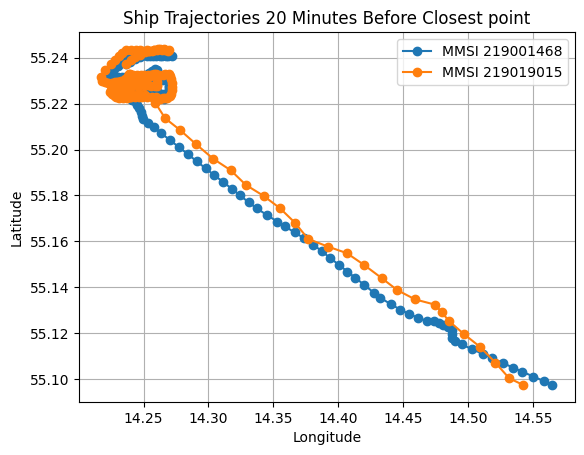

In [7]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

window_size_minutes = 20  # 20 minutes window
min_reports_per_minute = 1  # Minimum required frequency of reports

window_size_seconds = window_size_minutes * 60
min_reports_in_window = window_size_minutes * min_reports_per_minute

collision_time_str = "2021-12-13 06:18:00+02:00"
collision_time = pd.to_datetime(collision_time_str)

start_time = collision_time - timedelta(minutes=400)
end_time = collision_time

path = 'C:/Users/User/Desktop/data_folder/manipulated_data/aisdk-2021-12-13_processed'
all_files = glob.glob(path + "/part*.csv")
mmsi_list = [219001468, 219019015]


df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
    
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df[df['MMSI'].isin(mmsi_list)]
df.set_index('timestamp', inplace=True)
df.sort_index(inplace=True)

numeric_cols = df.select_dtypes(include=[np.number])
resampled = numeric_cols.groupby('MMSI').resample('1T').mean()
resampled.dropna(inplace=True)

if 'MMSI' in resampled.columns:
        resampled.drop(columns=['MMSI'], inplace=True)

resampled.reset_index(inplace=True)

filtered_df = pd.DataFrame()

for mmsi, group in resampled.groupby('MMSI'):
    group = group.sort_values('timestamp')
    group['count_in_window'] = group.rolling(f'{window_size_seconds}S', on='timestamp')['timestamp'].count()
    consistent_group = group[group['count_in_window'] >= min_reports_in_window]
    filtered_df = pd.concat([filtered_df, consistent_group])
    filtered_df = filtered_df.drop(columns=['count_in_window'])

filtered_df = resampled[(resampled['timestamp'] >= start_time) & (resampled['timestamp'] <= end_time)]

for mmsi in mmsi_list:
    mmsi_df = filtered_df[filtered_df['MMSI'] == mmsi].sort_values(by='timestamp')
    plt.plot(mmsi_df['long'], mmsi_df['lat'], marker='o', label=f'MMSI {mmsi}')

plt.title('Ship Trajectories 20 Minutes Before Closest point')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)

plt.show()

### Discussion
It was known that the goal of the project was to find two vessels that collided on December 13 th, 2021. However, I did not manage to find them.  
For the curiosity I did analyse particularly those two collided vessels and found that their closest point was ~40 meters, which is more that some other vessels in the dataset.   
I did not try to write a code such that those two vessels would be printed as a result artificially.   
The closest vessels I found are from 13 th day 6 am, which is around 3 hours past collision, and they might be related to the collision. 
